In [4]:
#importing all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from gensim.models import KeyedVectors


Loading the dataset

In [2]:
df = pd.read_csv("new_complaints3.csv") 

In [5]:
vectors = KeyedVectors.load('vectors.kv')

In [4]:
# Load vectors directly from the fileArgue
vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [26]:
#splitting the data into feature and label
X_data = df['new']
y_data = df['Product']

In [27]:
X_data

0         transworld systems inc \nis trying to collect ...
1         Over the past 2 weeks I have been receiving ex...
2         Pioneer has committed several federal violatio...
3         Previously on XX XX XXXX XX XX XXXX and XX XX ...
4         Hello This complaint is against the three cred...
                                ...                        
597869    1  Mailing Address is incorrect \n2  Date of B...
597870    I made a purchase of ##### on XXXX XXXX #### u...
597871    On XXXX XXXX #### I contacted XXXX XXXX who is...
597872    I can not get from chase who services my mortg...
597873    cfbp i would Like to file a complaint on Exper...
Name: new, Length: 597874, dtype: object

In [28]:
X = X_data.values
y = y_data.values

In [29]:
X

array(['transworld systems inc \nis trying to collect a debt that is not mine not owed and is inaccurate',
       'Over the past 2 weeks I have been receiving excessive amounts of telephone calls from the company listed in this complaint The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job The company does not have the right to harass me at work and I want this to stop It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work',
       'Pioneer has committed several federal violations against me a Private law abiding Federally Protected Consumer Each violation is a statutory cost of ##### each which does not include my personal cost and fees which shall be determined for taking time to address these issues Violations committed against me include but not limited to   1  Violated ## USC ####c  a   Communication without prior consent expressed permission  2  Violated ## USC ####d  Harass and oppressive use of inter

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=666, stratify=y)

In [31]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(X_train))

In [32]:
#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(X_train) 
x_val_seq = tokenizer.texts_to_sequences(X_val)

In [33]:
#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=250)
x_val_seq = pad_sequences(x_val_seq, maxlen=250)

In [34]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

138413


In [35]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

In [36]:
embedding_matrix.shape

(138414, 300)

In [36]:
from tqdm import tqdm
tqdm.pandas()

C:\Users\virah\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Build the embedding matrix

In [37]:
for word, i in tqdm(tokenizer.word_index.items()):
    try:
        embedding_vector = vectors[word]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_vector = vectors['UNK']
        embedding_matrix[i] = embedding_vector

100%|██████████| 138412/138412 [00:11<00:00, 12271.19it/s]


In [56]:
len(tokenizer.word_index)

138412

In [53]:
embedding_matrix.shape

(138413, 300)

In [38]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / size_of_vocabulary

0.9999927752450998

In [60]:
from sklearn.preprocessing import LabelBinarizer

In [61]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val   = lb.transform(y_val)

In [93]:
sequence_length = 250
#max_features = size_of_vocabulary
num_words = size_of_vocabulary

In [96]:
from keras.layers import Input, Embedding, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten

In [98]:
from keras.initializers import Constant

In [102]:
embedding_dim = 300 # Kim uses 300 here
num_filters = 100

inputs = Input(shape=(sequence_length,), dtype='int32')

# note the `trainable=False`, later we will make this layer trainable
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(inputs)

reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

# Note the relu activation which Kim specifically mentions
# He also uses an l2 constraint of 3
# Also, note that the convolution window acts on the whole 200 dimensions - that's important
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)

# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=9, activation='softmax')(dropout)

In [84]:
from keras import Model

In [103]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 250, 300)     41523900    input_13[0][0]                   
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 250, 300, 1)  0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 248, 1, 100)  90100       reshape_8[0][0]                  
_______________________________________________________________________________________

In [104]:
batch_size = 1500 # Kim uses 50 here, I have a slightly smaller sample size than num
history = model.fit(x_tr_seq, y_train, epochs=30, batch_size=batch_size, verbose=1,  
                    validation_data=(x_val_seq, y_val))

Epoch 1/30
319/319 [==============================] - 2811s 9s/step - loss: 1.9512 - accuracy: 0.4066 - val_loss: 1.6639 - val_accuracy: 0.4116
Epoch 2/30
319/319 [==============================] - 2870s 9s/step - loss: 1.6250 - accuracy: 0.4834 - val_loss: 1.5712 - val_accuracy: 0.5504
Epoch 3/30
319/319 [==============================] - 2851s 9s/step - loss: 1.5473 - accuracy: 0.5485 - val_loss: 1.4934 - val_accuracy: 0.5843
Epoch 4/30
319/319 [==============================] - 2655s 8s/step - loss: 1.4971 - accuracy: 0.5758 - val_loss: 1.4570 - val_accuracy: 0.5812
Epoch 5/30
319/319 [==============================] - 2652s 8s/step - loss: 1.4585 - accuracy: 0.5898 - val_loss: 1.4409 - val_accuracy: 0.5831
Epoch 6/30
319/319 [==============================] - 2639s 8s/step - loss: 1.4398 - accuracy: 0.5978 - val_loss: 1.3768 - val_accuracy: 0.6260
Epoch 7/30
319/319 [==============================] - 2633s 8s/step - loss: 1.4074 - accuracy: 0.6047 - val_loss: 1.3562 - val_accuracy:

In [111]:
import pickle

In [109]:
with open('trainHistoryDict_we_cnn', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [112]:
# serialize model to JSON
we_cnn = model.to_json()
with open("we_cnn.json", "w") as json_file:
    json_file.write(we_cnn)
# serialize weights to HDF5
model.save_weights("we_cnn.h5")
print("Saved model to disk")

Saved model to disk


In [114]:
from keras.models import model_from_json

# load json and create model
json_file = open('we_cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("we_cnn.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_val_seq, y_val, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 70.37%


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt',  encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [25]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = model['word']
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [79]:
embedding_matrix.shape

(138414, 300)

In [120]:
model = Sequential()
model.add(Embedding(size_of_vocabulary, 300, 
                           weights=[embedding_matrix], 
                           input_length=250, 
                           trainable=False))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 300)          41524200  
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                19264     
_________________________________________________________________
dense_13 (Dense)             (None, 9)                 585       
Total params: 41,544,049
Trainable params: 19,849
Non-trainable params: 41,524,200
_________________________________________________________________


In [121]:
history = model.fit(x_tr_seq, y_train, epochs=25, validation_data=(x_val_seq, y_val), batch_size=1025)

Epoch 1/25
467/467 [==============================] - 91s 196ms/step - loss: 1.3450 - acc: 0.5519 - val_loss: 1.0538 - val_acc: 0.6597
Epoch 2/25
467/467 [==============================] - 84s 180ms/step - loss: 0.9789 - acc: 0.6767 - val_loss: 0.9331 - val_acc: 0.6936
Epoch 3/25
467/467 [==============================] - 84s 180ms/step - loss: 0.9064 - acc: 0.6971 - val_loss: 0.8885 - val_acc: 0.7043
Epoch 4/25
467/467 [==============================] - 85s 183ms/step - loss: 0.8764 - acc: 0.7061 - val_loss: 0.8615 - val_acc: 0.7110
Epoch 5/25
467/467 [==============================] - 86s 185ms/step - loss: 0.8577 - acc: 0.7115 - val_loss: 0.8516 - val_acc: 0.7135
Epoch 6/25
467/467 [==============================] - 85s 182ms/step - loss: 0.8452 - acc: 0.7151 - val_loss: 0.8400 - val_acc: 0.7167
Epoch 7/25
467/467 [==============================] - 88s 189ms/step - loss: 0.8370 - acc: 0.7175 - val_loss: 0.8369 - val_acc: 0.7153
Epoch 8/25
467/467 [==============================] - 8

In [80]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [85]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=250,trainable=False)) 

#lstm layer
model.add(LSTM(128,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(9,activation='softmax')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc']) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          41524200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 128)          219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
Total params: 41,752,689
Trainable params: 228,489
Non-trainable params: 41,524,200
_________________________________________________________________
None


In [86]:
history = model.fit(np.array(x_tr_seq),np.array(y_train),batch_size=1025,epochs=10,
                    validation_data=(np.array(x_val_seq),np.array(y_val)))

Epoch 1/10
467/467 [==============================] - 4323s 9s/step - loss: 0.8615 - acc: 0.7115 - val_loss: 0.6122 - val_acc: 0.7921
Epoch 2/10
467/467 [==============================] - 4308s 9s/step - loss: 0.5873 - acc: 0.7995 - val_loss: 0.5511 - val_acc: 0.8123
Epoch 3/10
467/467 [==============================] - 6148s 13s/step - loss: 0.5415 - acc: 0.8153 - val_loss: 0.5170 - val_acc: 0.8240
Epoch 4/10
467/467 [==============================] - 5154s 11s/step - loss: 0.5177 - acc: 0.8230 - val_loss: 0.4987 - val_acc: 0.8291
Epoch 5/10
467/467 [==============================] - 3986s 9s/step - loss: 0.4996 - acc: 0.8287 - val_loss: 0.4851 - val_acc: 0.8326
Epoch 6/10
467/467 [==============================] - 4827s 10s/step - loss: 0.4855 - acc: 0.8330 - val_loss: 0.4773 - val_acc: 0.8358
Epoch 7/10
467/467 [==============================] - 5377s 12s/step - loss: 0.4739 - acc: 0.8370 - val_loss: 0.4712 - val_acc: 0.8375
Epoch 8/10
467/467 [==============================] - 4478

In [ ]:
print("Accuracy %s" % accuracy_score(pred_model, np.argmax(y_val, axis=-1)))
print(classification_report(np.argmax(y_val, axis=-1),pred_model))

In [98]:
pred_model = np.argmax(model.predict(x_val_seq), axis=-1)
print("Accuracy %s" % accuracy_score(pred_model, np.argmax(y_val, axis=-1)))
print(classification_report(np.argmax(y_val, axis=-1),pred_model))

Accuracy 0.8396571189629939
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      5172
           1       0.80      0.81      0.81     12941
           2       0.86      0.92      0.89     48487
           3       0.86      0.77      0.81     24883
           4       0.81      0.69      0.74      2563
           5       0.90      0.92      0.91     14084
           6       0.60      0.47      0.53      3873
           7       0.82      0.82      0.82      5407
           8       0.58      0.50      0.54      2165

    accuracy                           0.84    119575
   macro avg       0.78      0.75      0.76    119575
weighted avg       0.84      0.84      0.84    119575



In [4]:
#load the dataset(X_data) and the label (y_data) 
X_data = df['new']
y_data = df['Product']

In [5]:
X = X_data.values
y = y_data.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=666, stratify=y)

In [6]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val   = lb.transform(y_val)

In [7]:
vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(X_train)

CountVectorizer(lowercase=False, min_df=0)

In [8]:
X_train = vectorizer.transform(X_train)
X_val  = vectorizer.transform(X_val)

In [63]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01), kernel_initializer='glorot_normal'))
model.add(Dense(9, activation='softmax', kernel_regularizer=regularizers.l2(0.01), kernel_initializer='glorot_uniform'))
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               20261248  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 99        
Total params: 20,270,253
Trainable params: 20,270,253
Non-trainable params: 0
____________________________________________

In [9]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(9, activation='softmax'))
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8843264   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 99        
Total params: 8,844,013
Trainable params: 8,844,013
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=1025)

Epoch 1/5
467/467 [==============================] - 29s 61ms/step - loss: 0.7395 - acc: 0.7966 - val_loss: 0.5425 - val_acc: 0.8374
Epoch 2/5
467/467 [==============================] - 28s 61ms/step - loss: 0.4547 - acc: 0.8566 - val_loss: 0.4918 - val_acc: 0.8453
Epoch 3/5
467/467 [==============================] - 30s 65ms/step - loss: 0.3707 - acc: 0.8787 - val_loss: 0.4752 - val_acc: 0.8501
Epoch 4/5
467/467 [==============================] - 33s 70ms/step - loss: 0.3153 - acc: 0.8958 - val_loss: 0.4856 - val_acc: 0.8507
Epoch 5/5
467/467 [==============================] - 32s 69ms/step - loss: 0.2723 - acc: 0.9098 - val_loss: 0.4937 - val_acc: 0.8518


In [11]:
pred_model = np.argmax(model.predict(X_val), axis=-1)
print("Accuracy %s" % accuracy_score(pred_model, np.argmax(y_val, axis=-1)))
print(classification_report(np.argmax(y_val, axis=-1),pred_model))

Accuracy 0.8517666736357934
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      5172
           1       0.82      0.80      0.81     12941
           2       0.89      0.91      0.90     48487
           3       0.82      0.84      0.83     24883
           4       0.79      0.73      0.76      2563
           5       0.91      0.93      0.92     14084
           6       0.58      0.48      0.52      3873
           7       0.87      0.87      0.87      5407
           8       0.60      0.37      0.46      2165

    accuracy                           0.85    119575
   macro avg       0.78      0.75      0.76    119575
weighted avg       0.85      0.85      0.85    119575



In [79]:
 from keras.preprocessing.text import Tokenizer

In [81]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 179260 unique tokens.


In [85]:
X = tokenizer.texts_to_sequences(df['narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

NameError: name 'pad_sequences' is not defined

In [ ]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [83]:
from keras.layers import Embedding


In [ ]:
model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(13, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [162]:
X_val

<119575x85471 sparse matrix of type '<class 'numpy.int64'>'
	with 6529261 stored elements in Compressed Sparse Row format>

In [149]:
pred_model

array([[2.1068112e-04, 6.5074964e-05, 1.1395631e-01, ..., 3.2094610e-03,
        2.7522133e-04, 9.6498424e-04],
       [3.6948888e-05, 9.3445033e-06, 1.9738725e-03, ..., 1.3473543e-03,
        6.9955429e-05, 6.3340244e-04],
       [9.5675557e-07, 5.4205211e-05, 9.9896431e-01, ..., 9.0579044e-07,
        7.1399825e-07, 5.1870991e-08],
       ...,
       [1.4687306e-05, 6.4322440e-04, 6.2166578e-03, ..., 1.3471496e-03,
        1.4947487e-04, 9.1205431e-05],
       [1.0232003e-08, 7.6825409e-06, 9.9998629e-01, ..., 9.0880432e-09,
        7.1876329e-08, 3.2951439e-10],
       [1.9863099e-04, 3.4326483e-03, 1.7260011e-01, ..., 2.5184050e-03,
        7.0130843e-04, 3.0174191e-04]], dtype=float32)

In [32]:
df

,narrative,Product,word_count
1,transworld systems inc. \nis trying to collect...,Debt collection,18
3,"Over the past 2 weeks, I have been receiving e...",Debt collection,78
6,Pioneer has committed several federal violatio...,Debt collection,152
8,"Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...","Credit or consumer reporting, credit repair se...",171
9,Hello This complaint is against the three cred...,"Credit or consumer reporting, credit repair se...",428
...,...,...,...
1823677,"I made a purchase of {$500.00} on XXXX XXXX, 2...",Credit card or prepaid card,44
1823679,"I have been a victim if inquiry issue,","Credit or consumer reporting, credit repair se...",8
1823680,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who...",Mortgage,331
1823681,I can not get from chase who services my mortg...,Mortgage,21


In [96]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.savefig("plot.png")

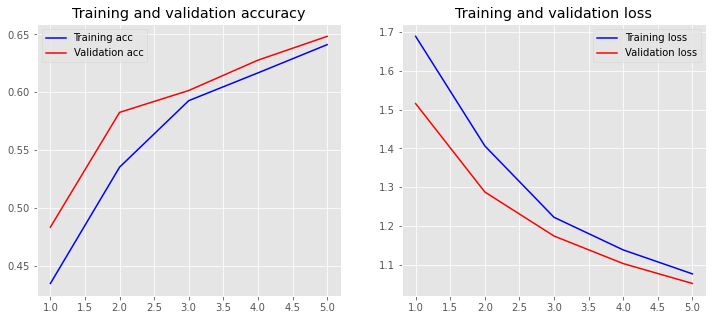

In [116]:
plot_history(history)

In [128]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [129]:
stop_words = set(stopwords.words('english'))
stemer = PorterStemmer()

def remove_SW_Stem(text):
    text=[stemer.stem(words) for words in text.split(" ") if words not in stop_words]
    return " ".join(text)

special_chars = re.compile('[^-9a-z#+_]')
add_space = re.compile('[/(){}\[\]\\@;]')

def clean_text(text):
    text=text.lower()
    text = add_space.sub(" ",text)
    text = special_chars.sub(" ",text)
    text = remove_SW_Stem(text)
    return text

In [130]:
df['narrative'] = df['narrative'].apply(lambda text:clean_text(text))

In [131]:
df

,narrative,Product,word_count
1,transworld system inc tri collect debt mine ...,Debt collection,18
3,past week receiv excess amount telephon cal...,Debt collection,78
6,pioneer commit sever feder violat privat law ...,Debt collection,152
8,previous xx xx xxxx xx xx xxxx xx xx xxxx r...,"Credit or consumer reporting, credit repair se...",171
9,hello complaint three credit report compani x...,"Credit or consumer reporting, credit repair se...",428
...,...,...,...
1823676,mail address incorrect date birth i...,Personal loan,19
1823677,made purchas xxxx xxxx use dis...,Credit card or prepaid card,44
1823680,xxxx xxxx contact xxxx xxxx branch man...,Mortgage,331
1823681,get chase servic mortgag own origin loan doc ...,Mortgage,21


In [134]:
df['narrative'][1748416]

'credit bureau investig disput xxxxxxxx xxxx xxxx account number xxxx  would known never payment made xx xx xxxx-xx xx xxxx  could verif never payment made account  updat credit report show   last payment   xx xx xxxx    payment histori show account current xx xx xxxx  account charg xx xx xxxx  significantli affect credit score process purchas first home  delet immedi  forc file lawsuit  purchas hous affect inaccuraci  file lawsuit immedi '

In [132]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


In [135]:
before_vect = df[['narrative']]
columnTransformer = ColumnTransformer( [('tfidf',TfidfVectorizer(stop_words=None, max_features=100000),'narrative')],
remainder='drop')
vector_transformer = columnTransformer.fit(before_vect)
vectorized_df = vector_transformer.transform(before_vect)

In [79]:
vectorized_df

<592935x99272 sparse matrix of type '<class 'numpy.float64'>'
	with 32223236 stored elements in Compressed Sparse Row format>

In [137]:
targetTransformer = ColumnTransformer( [('E',OneHotEncoder(dtype='int'))])

In [144]:
y=df['Product'].to_frame()

In [42]:
y

,Product
0,"Credit reporting, credit repair services, or o..."
1,Debt collection
2,"Credit reporting, credit repair services, or o..."
3,Debt collection
4,"Credit reporting, credit repair services, or o..."
...,...
1823678,Bank account or service
1823679,Credit reporting
1823680,Mortgage
1823681,Mortgage


In [141]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [142]:
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(vectorized_df, y)
X_train, x_test, Y_train, y_test = train_test_split(X_ROS,y_ROS,test_size=0.3,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

Accuracy 0.7989275484092732
                                                      precision    recall  f1-score   support

                         Checking or savings account       0.78      0.82      0.80     72885
                         Credit card or prepaid card       0.78      0.82      0.80     73008
Credit or consumer reporting, credit repair services       0.76      0.76      0.76     72446
                                     Debt collection       0.75      0.79      0.77     72432
         Money transfer or service, virtual currency       0.85      0.84      0.84     73035
                                            Mortgage       0.89      0.95      0.92     72579
                                       Personal loan       0.81      0.42      0.56     72688
                                        Student loan       0.91      0.93      0.92     72801
                               Vehicle loan or lease       0.69      0.85      0.76     72701

                              

In [139]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [140]:
smote = SMOTE(random_state=777,k_neighbors=18)
X_smote,y_smote = smote.fit_sample(vectorized_df,y)
X_train, x_test, Y_train, y_test = train_test_split(X_smote,y_smote,test_size=0.3,random_state=42)
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, Y_train)
pred_sgd = sgd.predict(x_test)
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))
print(classification_report(y_test,pred_sgd))

C:\Users\virah\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy 0.8304777909330482
                                                      precision    recall  f1-score   support

                         Checking or savings account       0.83      0.86      0.84     72885
                         Credit card or prepaid card       0.82      0.86      0.84     73008
Credit or consumer reporting, credit repair services       0.78      0.76      0.77     72446
                                     Debt collection       0.79      0.82      0.80     72432
         Money transfer or service, virtual currency       0.88      0.88      0.88     73035
                                            Mortgage       0.92      0.96      0.94     72579
                                       Personal loan       0.84      0.50      0.62     72688
                                        Student loan       0.94      0.95      0.94     72801
                               Vehicle loan or lease       0.71      0.89      0.79     72701

                              